# Introduction
OpenStreetMap (OSM) has a wealth of spatial data that is easily accessible via the Overpass API. This notebook explores how OSM data can be leveraged with other rich sources of spatial data. Since I'm a kiwi who's interested in public sector work, I'm using the spatial data available from StatsNZ. Also, I believe that the internet needs more analysis done with non-USA data!     

The particular focus this notebook is how external sources of data can be combined with local government spatial data. In brief, the notebook covers:
- Getting OSM data via Overpass
- Calculating way polygon centroids as POI
- Plotting POIs on Folium map
- Loading administrative boundaries from Stats NZ
- Aggregating data within an administrative boundary

The motivation for this notebook is to obtain richer features for spatial flow modelling. I started out following the [excellent tutorial by Adam Dennett for modelling commuting patterns](https://rpubs.com/adam_dennett/376877). I [hacked out an equivalent in R for Wellington City commuters](https://github.com/shriv/wellington-commutes). But, by the end of the notebook, I realised that: (1) I needed much more exposure to the spatial data used by Stats NZ, and (2) the model was terrible; embarrassingly so - with 0% explained variance. Of course, the reason is that a garbage feature gives garbage predictions. In my case, the destination 'attractiveness' feature was beyond hopeless - the data actually had the opposite to expected dependence! I realised that I could add better features to the model if I only knew how to join the StatsNZ spatial data with other sources. This notebook works through an end to end generation of destination attractiveness features with OSM data: (1) number of commercial/ office buildings aggregated within the StatsNZ Statistical Area Unit (SA), and (2) land area covered by residential buildings within an SA. 

The key idea of these new features is to better represent where offices are located vs. residential areas. I want to be able to combine these to create a single feature that is correlated to workplace. 

In [2]:
# Import some packages
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import geopandas 
from shapely.geometry import Point, Polygon

# User modules
import utils.data_processing as dp

# Some configs
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
#%matplotlib inline

# Get OSM data
OSM data is amazingly rich. It has two key components: (1) spatial objects,  and (2) a taxonomy for tagging the spatial objects. The root spatial primitive is a *node*. A collection of nodes makes up a *way*. Ways can be polygons or lines. Both nodes and ways [can be tagged](https://wiki.openstreetmap.org/wiki/Tags) with the extensive taxonomy specified by OSM. 

In [a previous analysis](https://github.com/shriv/fuel-stations), I focused on getting and analysing nodes from OSM. At the time, I believed that way data was not useful since it was a polygon and thus too complex to do anything with. I'm a changed woman now - way data is the *way forward*!

Puns aside, the reason any polygon (way, spatial boundaries etc.) data is difficult to harness is because it actually requires understanding of spatial data manipulation - from theoretical aspects of projections and datums to reading in a diverse array spatial data formats. The problem gets more complicated when one wants to join  spatial datasets from different sources! Geo-munging is not trivial and sometimes the specificity of the datasets means that the entrypoint for a newbie is rather daunting! There are plenty of resources on the interwebs on geo-munging for sure but sadly none that met my needs. Hence, this little notebook. It brings together OSM data and spatial boundary datasets to derive interesting spatial features.

There are 3 key steps to get data from OSM:
- Generate the boundary box for the query
- Write the query
- Request data from OSM

The final step is to transfrom the data into one that's suitable for the particular application. I've requested the data as JSON but I'm managing it with pandas / geopandas for analysis. 

## Define bounding box
I've [written at some length about bounding boxes](http://htmlpreview.github.io/?https://github.com/shriv/fuel-stations/blob/master/html/Fuel%20Stations%20Analysis.html#Set-bounding-box) in my previous analysis with node data from OSM. So, here I'll just say that the bounding box defines a rectangular region that we're interested in with lattitude and longitude. The visual tool [here](http://boundingbox.klokantech.com/) can be used to get the vertices of the box. 

In [3]:
# Define bounding box (W, S, E, N) for the area of Wellington we're interested in
general_bbox = [174.5813,-41.4552,175.0722,-41.1527]

# Separate out the bounding box list into 4 vertices. 
south = general_bbox[1]
west = general_bbox[0]
north = general_bbox[3]
east = general_bbox[2]

# Set OSM bounding box
osm_bbox = [south, west, north, east]

## Generate Overpass query
Overpass is the API through which we access OSM data. I've cannibalised my Overpass query from various sources including [Geoff Boening's spatial analysis course notes](https://github.com/gboeing/urban-data-science/blob/master/20-Accessibility-Walkability/pandana-accessibility-demo-full.ipynb). The [Overpass Turbo site](http://overpass-turbo.eu/) can be used to test out the queries - you can inspect the data visually and through the specified output format. 

Since I'm interested in commerical buildings, I've generated a simple query for the Wellington City region that gets all *ways* that are tagged as commercial type buildings. The specific tags associated with these buildings are given in the code below. 

The query structure for my example is pretty simple. The following things need to be specified: 
- output format 
- timeout in seconds
- the particular spatial entities we want to retrieve 
    - done by filtering on tags
- the bounding box for the data

In [4]:
# What types of entitities do we want to get? 
tags = ["commercial", "office", "retail", "industrial"]
objects = ['way'] # like way, node, relation
entity = 'building'
osm_objects = [entity] + tags + objects

# Generate the query string
compactOverpassQLstring = dp.generate_overpass_query(tags, objects, osm_bbox, entity)
print(compactOverpassQLstring)

[out:json][timeout:60];(way["building" ~ "commercial"](-41.4552,174.5813,-41.1527,175.0722);way["building" ~ "office"](-41.4552,174.5813,-41.1527,175.0722);way["building" ~ "retail"](-41.4552,174.5813,-41.1527,175.0722);way["building" ~ "industrial"](-41.4552,174.5813,-41.1527,175.0722););out body;>;out skel qt;


## Get data
The retreived JSON data can be transformed into a Pandas dataframe. At the moment, I have a minor problem with saving the way data as CSV - some of the node lists were getting truncated. This means that every re-run of the code will involve re-querying. Not great - but manageable at the moment since I'm not retreiving much data.  

In [5]:
# Get Data
import importlib
importlib.reload(dp)
osmdf = dp.get_osm_data(compactOverpassQLstring, osm_bbox, osm_objects)
osmdf.head()

,LINZ2OSM:dataset,LINZ2OSM:layer,LINZ2OSM:source_version,addr:city,addr:country,addr:housename,addr:housenumber,addr:postcode,addr:street,alt_name,...,roof:levels,shop,smoking,source,substation,type,voltage,website,wikidata,year_of_construction
0,NaN,NaN,NaN,Wellington,NaN,NaN,100,6011.0,Willis Street,NaN,...,NaN,NaN,NaN,NaN,NaN,way,NaN,NaN,Q10323215,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,way,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,Wellington,NZ,NaN,150,NaN,Willis Street,NaN,...,NaN,NaN,NaN,NaN,NaN,way,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,way,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,way,NaN,NaN,NaN,NaN


# Calculate polygon centroids

In [7]:
importlib.reload(dp)
osmdf_clean = dp.extend_ways_to_node_view(osmdf)
osmdf_centroids = osmdf_clean.groupby('way_id').agg({'lat': 'mean', 'lon': 'mean' }).reset_index()

# Plot centroids

In [8]:
map_bldgs = folium.Map(location=[-41.29, 174.8], zoom_start = 11)
    
for each in osmdf_centroids.iterrows():
    folium.CircleMarker(location = [each[1]['lat'],each[1]['lon']], radius=3, 
                        color='grey', fill=True).add_to(map_bldgs)

map_bldgs

# Get Administrative boundaries

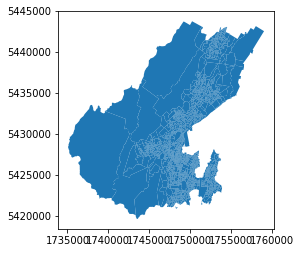

In [8]:
# Load ESRI GDB boundary files at two levels: area units; meshblock
nz_mesh = geopandas.read_file('../wellington-commutes/data/meshblock-2013/meshblock-2013.gdb/')
nz_area_unit = geopandas.read_file('../wellington-commutes/data/area-unit-2013/area-unit-2013.gdb/')

# Filter meshblocks by Wellington City TA
wlg_mesh = nz_mesh.query('TLAName == "Wellington City"')
wlg_mesh.plot()

# Filter or dissolve spatial boundaries

## Filter

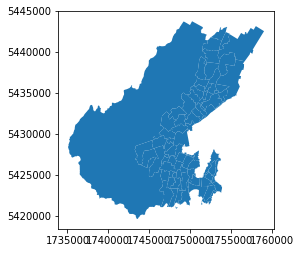

In [9]:
nz_area_unit.columns = ['AreaUnitCode', 'AU2013_V1_00_NAME','AREA_SQ_KM',
                        'LAND_AREA_SQ_KM','Shape_Length','geometry']
wlg_codes = wlg_mesh[['AreaUnitCode']]
wlg_area_units = nz_area_unit[nz_area_unit['AreaUnitCode'].isin(wlg_codes['AreaUnitCode'])]
wlg_area_units.plot()

## Dissolve

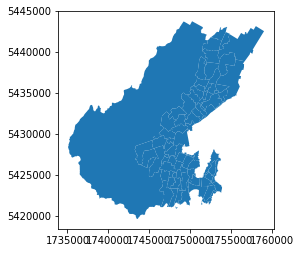

In [10]:
wlg_area_unit_from_mesh = wlg_mesh.dissolve(by='AreaUnitName')
wlg_area_unit_from_mesh.plot()

# Aggregating within spatial boundary

## POIs

In [11]:
# sp_osmdf_centroids = geopandas.GeoDataFrame(osmdf_centroids, crs=nz_area_unit.crs)
sp_osmdf_centroids =  dp.coords_df_to_geopandas_points(osmdf_centroids)

In [12]:
bldgs_wgtn = geopandas.sjoin(wlg_area_units, sp_osmdf_centroids, how='inner', op='intersects')

In [13]:
(bldgs_wgtn
 .groupby('AU2013_V1_00_NAME')
 .agg({'way_id': 'count'})
 .reset_index()
 .sort_values('way_id', ascending=False)
 .head(10))

,AU2013_V1_00_NAME,way_id


## Areas

In [14]:
# What types of entitities do we want to get? Currently restricted to amenities
tags = ["residential"]
objects = ['way'] # like way, node, relation
entity = 'landuse'
osm_objects = [entity] + tags + objects 

# Generate the query string
compactOverpassQLstring = dp.generate_overpass_query(tags, objects, osm_bbox, entity)
# Get Data
osmdf = dp.get_osm_data(compactOverpassQLstring, osm_bbox, osm_objects)

In [15]:
importlib.reload(dp)
osmdf_clean = dp.extend_ways_to_node_view(osmdf)
points_osmdf_clean = dp.coords_df_to_geopandas_points(osmdf_clean)
poly_osmdf_clean = dp.geopandas_points_to_poly(points_osmdf_clean)
poly_osmdf_clean = poly_osmdf_clean.to_crs(epsg=2193)

In [16]:
residential_wgtn = geopandas.sjoin(wlg_area_units, poly_osmdf_clean, how='right', op='contains')
residential_wgtn_proj = residential_wgtn.to_crs(epsg=2193)

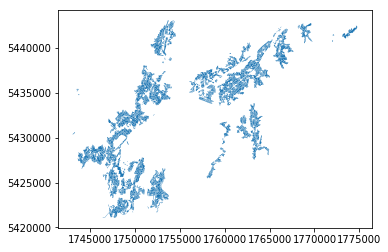

In [17]:
residential_wgtn_proj.plot()

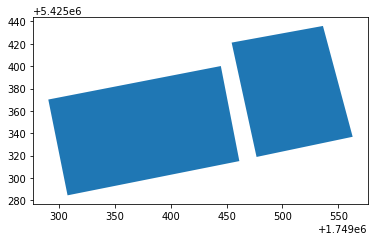

In [18]:
residential_wgtn.reset_index()[residential_wgtn.reset_index()['AU2013_V1_00_NAME'] == 'Adelaide'].plot()

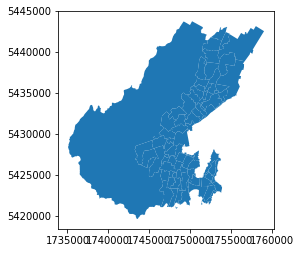

In [19]:
wlg_area_units.plot()

### Statistical units vs. residential areas

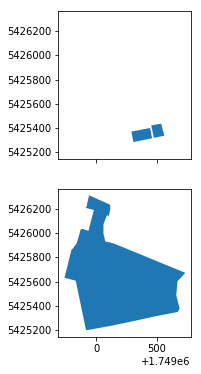

In [20]:
dp.plot_unit_residential(residential_wgtn, wlg_area_units, 'Adelaide')

In [21]:
residential_wgtn_proj['residential_area'] = residential_wgtn_proj['geometry'].area / 10**6
residential_area = (residential_wgtn_proj
                    .groupby(['AU2013_V1_00_NAME', 'LAND_AREA_SQ_KM'])
                    .agg({'residential_area': 'sum'})
                    .reset_index())
residential_area['residential_area_frac'] = residential_area['residential_area']/ residential_area['LAND_AREA_SQ_KM']

In [22]:
residential_area.head()

,AU2013_V1_00_NAME,LAND_AREA_SQ_KM,residential_area,residential_area_frac
0,Adelaide,0.550706,0.022525,0.040902
1,Aro Street-Nairn Street,0.834712,0.200180,0.239819
2,Awarua,1.892623,0.517553,0.273458
3,Berhampore East,0.392642,0.102187,0.260256
4,Berhampore West,0.966116,0.221859,0.229640


# Filtering with other spatial data

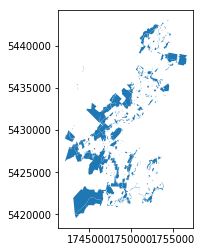

In [23]:
wcc_urban = geopandas.read_file('zip://./data/WCC_Parks_and_Reserves.zip')
wcc_urban_proj = wcc_urban.to_crs(wlg_area_units.crs)
wcc_urban_proj.plot()

In [24]:
urban_wlg_area_units = geopandas.overlay(wlg_area_units, wcc_urban_proj, how='difference')
urban_wlg_area_units.shape

(79, 6)

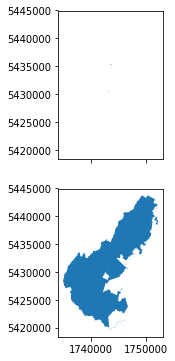

In [25]:
dp.plot_unit_residential(residential_wgtn, urban_wlg_area_units, 'Makara-Ohariu')

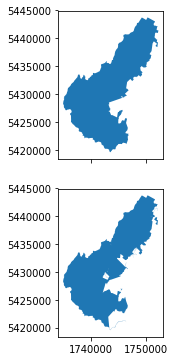

In [26]:
dp.plot_unit_residential(wlg_area_units, urban_wlg_area_units, 'Makara-Ohariu')

In [27]:
poly_osmdf_clean_proj = poly_osmdf_clean.to_crs(epsg=2193)

In [28]:
urban_wlg_area_units.crs= poly_osmdf_clean.crs
urban_wlg_area_units_proj = urban_wlg_area_units.to_crs(epsg=2193)

In [29]:
urban_wlg_area_units_proj['urban_area'] = urban_wlg_area_units_proj['geometry'].area / 10**6
residential_urban_wgtn_proj = geopandas.sjoin(poly_osmdf_clean_proj, urban_wlg_area_units_proj,  how='inner', op='within')


In [30]:
urban_area_proj = (urban_wlg_area_units_proj
                   .groupby(['AU2013_V1_00_NAME'])
                   .agg({'urban_area': 'sum'})
                   .reset_index())

residential_urban_wgtn_proj['residential_area'] = residential_urban_wgtn_proj['geometry'].area / 10**6
urban_residential_area = (residential_urban_wgtn_proj
                    .groupby(['AU2013_V1_00_NAME'])
                    .agg({'residential_area': 'sum'})
                    .reset_index())
# urban_residential_area = pd.merge(urban_residential_area, urban_area_proj, how='inner')
# urban_residential_area['residential_area_frac'] = urban_residential_area['residential_area']/ urban_residential_area['urban_area']

# Trying out LINZ residential area dataset

In [31]:
nz_residential_linz = geopandas.read_file('../wellington-commutes/data/residential-area/nz-residential-area-polygons-topo-150k.gdb')
wlg_residential_linz = nz_residential_linz[(nz_residential_linz['name'] == 'Wellington') | 
                                          (nz_residential_linz['name'] == 'Makara') |
                                          (nz_residential_linz['name'] == 'Porirua') | 
                                          (nz_residential_linz['name'] == 'Lower Hutt')]

In [32]:
nz_buildings_linz = geopandas.read_file('../wellington-commutes/data/buildings/nz-building-polygons-topo-150k.gdb')

In [33]:
linz_wgtn = geopandas.overlay(wlg_area_units, wlg_residential_linz, how='intersection')
bldgs_wgtn = geopandas.overlay(wlg_area_units, nz_buildings_linz, how='intersection')

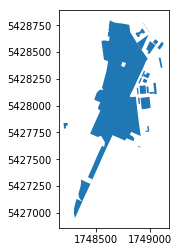

In [34]:
bldgs_wgtn[bldgs_wgtn['AU2013_V1_00_NAME'] == "Lambton"].plot()

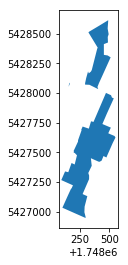

In [35]:
linz_wgtn[linz_wgtn['AU2013_V1_00_NAME'] == "Lambton"].plot()

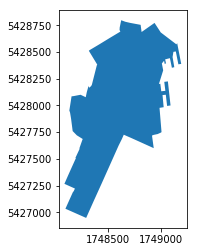

In [36]:
wlg_area_units[wlg_area_units['AU2013_V1_00_NAME'] == "Lambton"].plot()

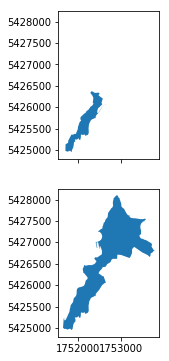

In [37]:
dp.plot_unit_residential(linz_wgtn, wlg_area_units, 'Maupuia')

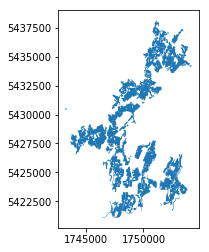

In [38]:
linz_wgtn.plot()

In [42]:
linz_wgtn['residential_area'] = linz_wgtn['geometry'].area / 10**6
bldgs_wgtn['urban_area'] = bldgs_wgtn['geometry'].area / 10**6

residential_area_linz = (linz_wgtn
                        .groupby(['AU2013_V1_00_NAME'])
                        .agg({'residential_area': 'sum'})
                        .reset_index())

buildings_area_linz = (bldgs_wgtn
                        .groupby(['AU2013_V1_00_NAME'])
                        .agg({'urban_area': 'sum'})
                        .reset_index())

all_area_linz = pd.merge(residential_area_linz, buildings_area_linz)
all_area_linz['residential_area_frac'] = all_area_linz['residential_area'] / (all_area_linz['urban_area'] + all_area_linz['residential_area'])
all_area_linz

,AU2013_V1_00_NAME,residential_area,urban_area,residential_area_frac
0,Adelaide,0.026478,1.586126e-01,0.143054
1,Aro Street-Nairn Street,0.372567,1.227103e-02,0.968114
2,Berhampore West,0.343880,2.327919e-02,0.936596
3,Brooklyn,0.826322,3.177900e-02,0.962966
4,Churton Park North,0.679048,8.246416e-03,0.988002
5,Churton Park South,0.782209,1.784030e-02,0.977701
6,Crofton Downs,0.421256,1.697590e-02,0.961263
7,Glenside North,0.033642,1.080442e-02,0.756912
8,Happy Valley-Owhiro Bay,0.389256,1.568835e-02,0.961258
9,Hataitai North,0.895948,3.000222e-02,0.967598


In [ ]:
(residential_area_linz
 .sort_values('residential_area_frac')
 .head(20))